<a href="https://colab.research.google.com/github/yongbin02/AI/blob/main/4%EC%A3%BC%EC%B0%A8/breast_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AI/AI-breast/data/breast_cancer.csv").dropna()
df.head()

,Unnamed: 0,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [44]:
# 라벨 분포 확인
print(df['label'].value_counts())

label
1    357
0    212
Name: count, dtype: int64


## 데이터 준비

In [45]:
# 독립변수 및 종속변수 분리
X = df.drop(columns=["label"])
y = df["label"]

In [46]:
# 스케일링 진행
scaler = StandardScaler()
X = scaler.fit_transform(X)

# one-hot encoding 방식으로 변경하지 않음
# 다중 분류 문제가 아닌 이진 분류 문제이기 때문
# Y = pd.get_dummies(y).values

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

## 딥러닝 모델 구축

In [47]:
model = models.Sequential([
    # 인풋 레이어 분리 (오류 메시지)
    layers.Input(shape=(X.shape[1],)),
    # 1번 층: 64개의 뉴런을 가진 입력층. 활성화 함수는 'relu'
    layers.Dense(64, activation="relu"),
    # 과적합 방지를 위해 30%의 뉴런을 랜덤하게 끔 (학습 방해)
    layers.Dropout(0.3),
    # 2번 층: 32개의 뉴런을 가진 은닉층.
    layers.Dense(32, activation="relu"),
    # 3번 층: 최종 결과가 1일 확률을 0과 1사이의 값으로 출력하는 층. 활성화 함수는 'sigmoid'
    # 이진 분류는 softmax가 아닌 sigmoid를 사용하는 경우가 더 효율적임
    # 유방암일 확률을 판단하면, 자동으로 아닐 확률이 계산되기 때문
    layers.Dense(1, activation="sigmoid")
])

## 모델 학습 설정

In [48]:
model.compile(
    optimizer="adam",                  # 최적화 도구
    # 손실 함수로 binary_crossentropy 채택
    # 유방암인지 아닌지를 판단하는 이진 분류 문제이기 때문
    loss="binary_crossentropy",
    metrics=["accuracy"]               # 평가 기준 (정확도)
)

## 모델 훈련

In [50]:
# 조기 종료 콜백 정의 (과적합 방지)
# 'val_loss'를 모니터링, 5 에포크 동안 성능 개선이 없으면 훈련을 중단
# 가장 성능이 좋았던 시점의 가중치를 모델에 복원
early_stopping = EarlyStopping(
    monitor='val_loss',          # 모니터링할 지표
    patience=5,                  # 개선이 없어도 참을 에포크 수
    restore_best_weights=True    # 가장 좋았던 가중치로 복원
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # 훈련 중 성능 검증을 위해 20%를 따로 떼어놓음
    epochs=100,             # 전체 데이터를 100번 반복 학습
    batch_size=10,          # 16개 데이터마다 한 번씩 정답과 비교하며 업데이트
    verbose=1,
    # fit 함수에 callbacks 리스트를 전달
    callbacks=[early_stopping]
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6859 - loss: 0.5761 - val_accuracy: 0.9890 - val_loss: 0.1854
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9578 - loss: 0.1971 - val_accuracy: 0.9890 - val_loss: 0.0939
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.0936 - val_accuracy: 1.0000 - val_loss: 0.0643
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.0772 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0694 - val_accuracy: 0.9890 - val_loss: 0.0435
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9746 - loss: 0.0509 - val_accuracy: 0.9890 - val_loss: 0.0409
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - loss: 0.0622 - val_accuracy: 0.9780 - val_loss: 0.0389
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9857 - loss: 0.0449 - val_accuracy: 0.9780 - v

## 학습과정 시각화

In [51]:
# 테스트 데이터 예측 수행 (0과 1사이의 확률)
y_pred = model.predict(X_test)

# 정답 클래스 준비 (0과 1사이의 확률이므로 np로 분류 불필요)
y_test_class = y_test

# 예측 클래스 준비 (확률을 0과 1로 변환) - 기준점 0.5
y_pred_class = (y_pred > 0.5).astype("int32")

# 학습 곡선
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


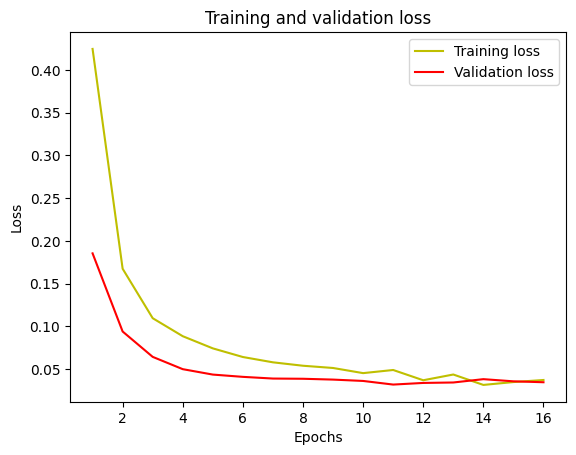

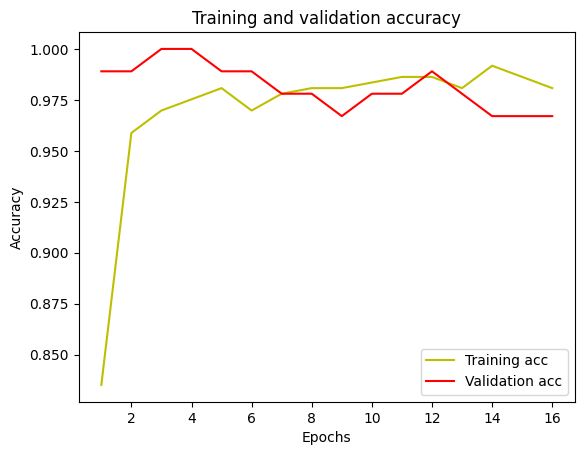

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 최종 성능 평가

In [53]:
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        47
           1       0.97      0.94      0.95        67

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114

[[45  2]
 [ 4 63]]
